In [1]:
import numpy as np
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
from itertools import chain
from mpl_toolkits.basemap import Basemap
import os
import warnings

In [2]:

def draw_map(m, scale=0.2):
    # draw a shaded-relief image
    # m.shadedrelief(scale=scale)
    m.drawlsmask(land_color='gray',ocean_color='white',lakes=True)
    # lats and longs are returned as a dictionary
    lats = m.drawparallels(np.linspace(-90, 90, 13))
    lons = m.drawmeridians(np.linspace(-180, 180, 13))

    # keys contain the plt.Line2D instances
    lat_lines = chain(*(tup[1][0] for tup in lats.items()))
    lon_lines = chain(*(tup[1][0] for tup in lons.items()))
    all_lines = chain(lat_lines, lon_lines)
    
    # cycle through these lines and set the desired style
    for line in all_lines:
        line.set(linestyle='-', alpha=0.3, color='w')


In [3]:
def mask_observations(observations, inversion):
    new_inversion = np.copy(inversion)
    for i in range(len(observations)):
        for j in range(len(observations[0])):
            if np.isnan(observations[i][j]):
                new_inversion[i][j] = np.nan
    return new_inversion


In [4]:
cs = np.load("../data/CPOM/freeboard_daily_processed/CS2_CPOM/dailyFB_50km_2018-2019_season.pkl", allow_pickle=True)
ak = np.load("../data/CPOM/freeboard_daily_processed/AK_CPOM/dailyFB_50km_2018-2019_season.pkl", allow_pickle=True)


grid_x = np.load("WG_x.npy")
grid_y = np.load("WG_y.npy")

lon_g = np.load('will_lons.npy')[1:, 1:]
lat_g = np.load('will_lats.npy')[1:, 1:]

sliding_window = 30

shape = (sliding_window, 160, 160)
ak_map = np.empty(shape)
cs_map = np.empty(shape)


for i, date in enumerate(list(cs.keys())[-sliding_window:]):
    cs_map[i] += cs[date][:160, :160]
    ak_map[i] += ak[date][:160, :160]



with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    cs_mean = np.nanmean(cs_map, axis=0)
 
    ak_mean = np.nanmean(ak_map, axis=0)


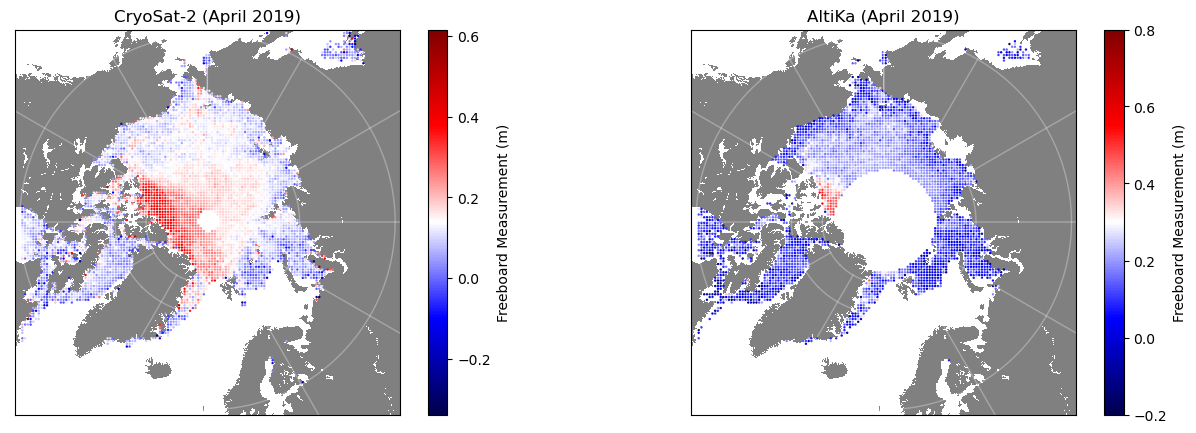

In [5]:
fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=cs_mean, cmap="seismic")
plt.colorbar(label=r'Freeboard Measurement (m)')
plt.title("CryoSat-2 (April 2019)")

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ak_mean, cmap="seismic", vmin=-0.2, vmax=0.8)
plt.colorbar(label=r'Freeboard Measurement (m)')
plt.title('AltiKa (April 2019)')

plt.show()

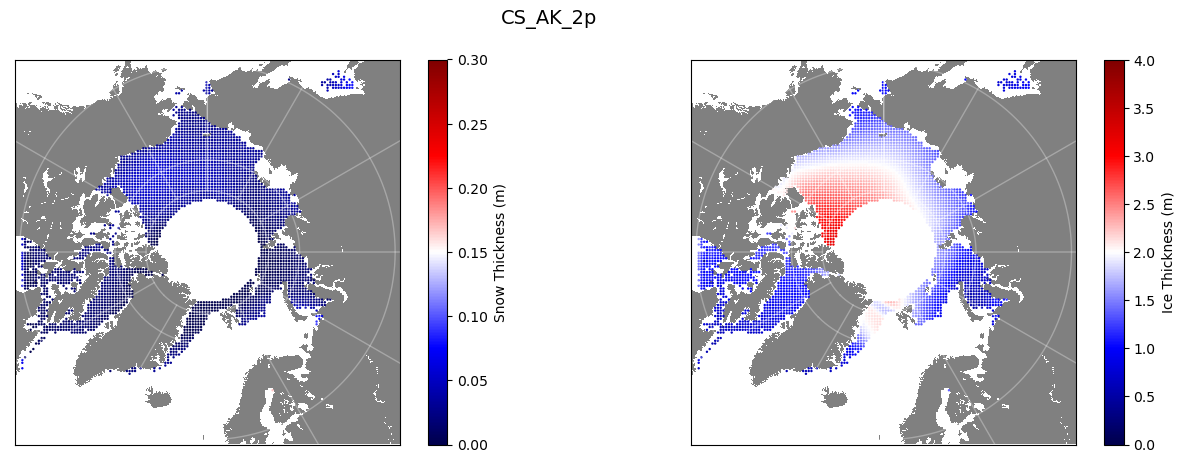

In [6]:
snow_mat = np.loadtxt("images/dailyFB_50km_2018-2019_season.pkl_snow")
ice_mat = np.loadtxt("images/dailyFB_50km_2018-2019_season.pkl_ice")

snow_mat = mask_observations(ak_mean, snow_mat)
ice_mat = mask_observations(ak_mean, ice_mat)

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)

fig.suptitle("CS_AK_2p", fontsize=14)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=snow_mat, cmap="seismic", vmin=0, vmax=0.3)
plt.colorbar(label=r'Snow Thickness (m)')

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=ice_mat, cmap="seismic", vmin=0, vmax=4)
plt.colorbar(label=r'Ice Thickness (m)')

plt.show()

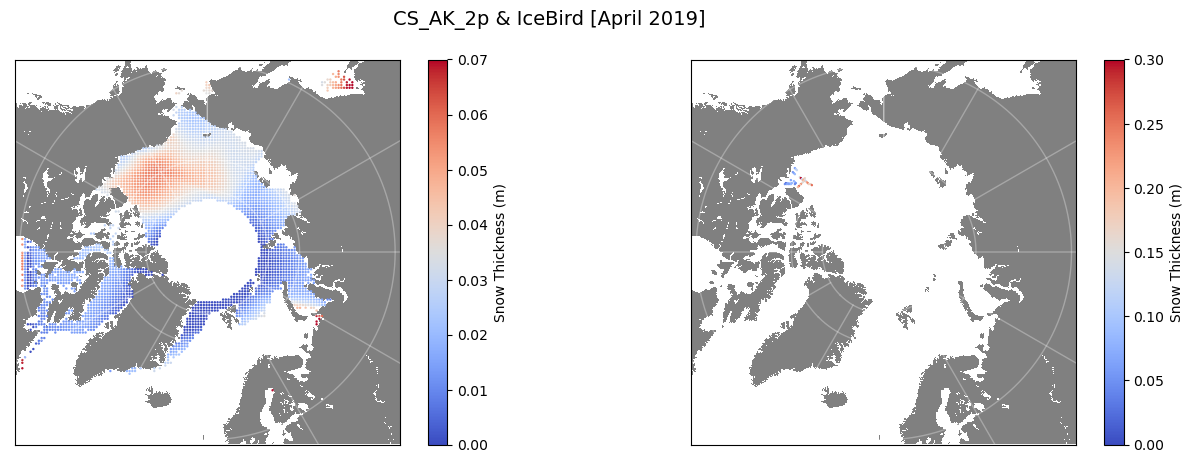

In [8]:
icebird = np.loadtxt("../data_validation/icebird2019.txt")

fig = plt.figure(figsize=(16, 5))
ax = fig.add_subplot(121)

fig.suptitle("CS_AK_2p & IceBird [April 2019]", fontsize=14)

m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(lon_g, lat_g, latlon=True, alpha=1, s=0.5, c=snow_mat, cmap="coolwarm", vmin=0, vmax=0.07)
plt.colorbar(label=r'Snow Thickness (m)')

ax = fig.add_subplot(122)
m = Basemap(projection='lcc', resolution=None, lat_0=-90, lon_0=0, lat_1=89.9, lon_1=180, width=0.7E7, height=0.7E7)
draw_map(m)
m.scatter(icebird[:,0], icebird[:,1], latlon=True, alpha=1, s=0.5, c=icebird[:,2], cmap="coolwarm", vmin=0, vmax=0.3)
plt.colorbar(label=r'Snow Thickness (m)')

plt.show()

In [9]:
snow_thickness = []

for i in range(160):
        for j in range(160):
            if not np.isnan(snow_mat[i][j]):
                snow_thickness.append([lon_g[i][j], lat_g[i][j], snow_mat[i][j]])                    

In [11]:
icebird = np.loadtxt("../data_validation/icebird2019.txt")

inverse_snow = []

for i in range(39):

# Convert data to NumPy array for efficient calculations
    snow_thickness_array = np.array(snow_thickness)

# Calculate the Euclidean distances between each data point and the target point
    distances = np.sqrt((snow_thickness_array[:, 0] - icebird[i,0])**2 +
                    (snow_thickness_array[:, 1] - icebird[i,1])**2)

# Find the index of the minimum distance
    min_distance_index = np.argmin(distances)

    inverse_snow.append(snow_thickness_array[min_distance_index,2])


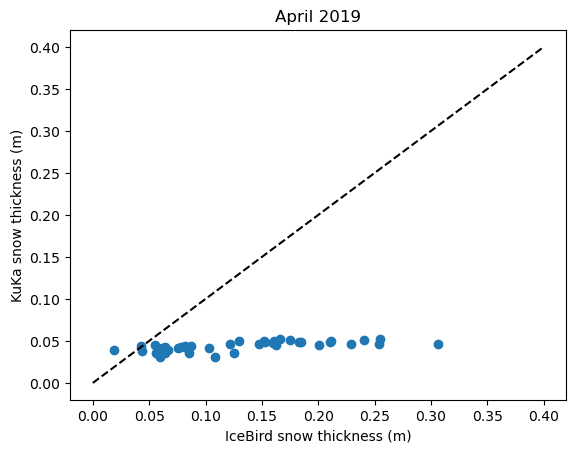

In [12]:
plt.scatter(icebird[:,2], inverse_snow)
plt.plot([0,0.4], [0,0.4], 'k--')
plt.title("April 2019")
plt.xlabel('IceBird snow thickness (m)')
plt.ylabel('KuKa snow thickness (m)')
plt.show()

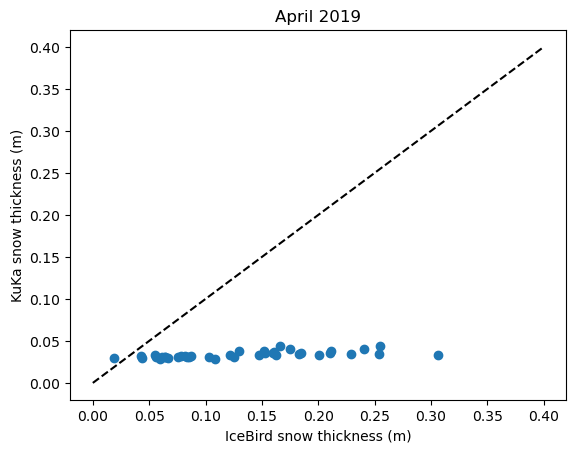

In [ ]:
plt.scatter(icebird[:,2], inverse_snow)
plt.plot([0,0.4], [0,0.4], 'k--')
plt.title("April 2019")
plt.xlabel('IceBird snow thickness (m)')
plt.ylabel('KuKa snow thickness (m)')
plt.show()

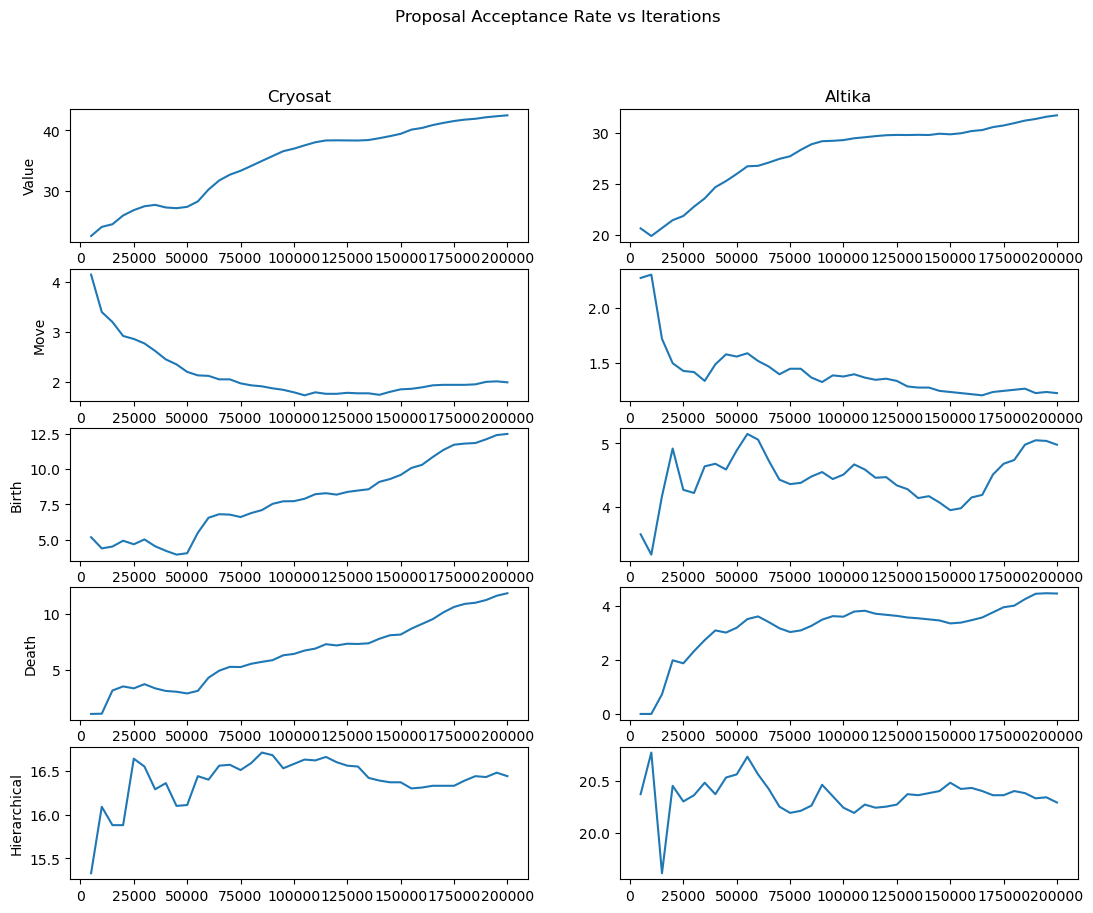

In [2]:
file = 'results/log.txt-000'

iterations = np.arange(5000,200001,5000)

keywords = ["Value", "Move", "Birth", "Death", "Hierarchical"]

rate = {key: {"snow": [], "ice": []} for key in keywords}

with open(file) as f:
    for line in f:
        data = line.split()

        for key in keywords:
            if key in line:
                rate[key]["snow"].append(float(data[4]))
                rate[key]["ice"].append(float(data[9]))
            

plt.figure(figsize=(13,10))
plt.suptitle('Proposal Acceptance Rate vs Iterations')

plt.subplot(5,2,1)
plt.plot(iterations, rate["Value"]["snow"], '-')
plt.ylabel("Value")
plt.title('Cryosat')

plt.subplot(5,2,2)
plt.plot(iterations, rate["Value"]["ice"],'-')
plt.title('Altika')

plt.subplot(5,2,3)
plt.plot(iterations, rate["Move"]['snow'],'-')
plt.ylabel("Move")

plt.subplot(5,2,4)
plt.plot(iterations, rate["Move"]['ice'],'-')

plt.subplot(5,2,5)
plt.plot(iterations, rate["Birth"]['snow'],'-')
plt.ylabel("Birth")
plt.subplot(5,2,6)
plt.plot(iterations, rate["Birth"]['ice'],'-')

plt.subplot(5,2,7)
plt.plot(iterations, rate["Death"]['snow'],'-')
plt.ylabel("Death")
plt.subplot(5,2,8)
plt.plot(iterations, rate["Death"]['ice'],'-')

plt.subplot(5,2,9)
plt.plot(iterations, rate["Hierarchical"]['snow'],'-')
plt.ylabel("Hierarchical")
plt.subplot(5,2,10)
plt.plot(iterations, rate["Hierarchical"]['ice'],'-')

plt.show()